# **Import , and Load Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from nltk import word_tokenize , sent_tokenize , WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,  confusion_matrix

In [2]:
os.chdir("D:/NLP Text data")
print(os.listdir())

['BJT.txt', 'IMBD-Dataset-', 'IMDB Dataset.csv', 'model_weights_RNN.pth', 'Mosfet.txt', 'Solid state devices.txt', 'Transistor as amplifier.txt']


In [3]:
data = pd.read_csv('IMDB Dataset.csv')

# **preprocessing text**

In [4]:
def preprocessing(text) :
    punc = set(string.punctuation)
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    big_tokens = sent_tokenize(str(text))
    preprocessed = []
    for i in big_tokens :
        small_tokens = word_tokenize(i)
        filterd = [ lemmatizer.lemmatize(i.lower()) for i in small_tokens if ( i not in stop_words) and ( i not in punc) and (i.isdigit() == 0)]
        preprocessed.append(" ".join(filterd))
    return " ".join(preprocessed)
data["review_processed"] = data['review'].apply(preprocessing)
print(data.shape)

(50000, 3)


# **Convert Words to Numerical Sequences**

In [5]:
all_text = []
def alltext(text) :
    all_text.append(word_tokenize(text))
data['review_processed'].apply(alltext)

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: review_processed, Length: 50000, dtype: object

In [6]:
all_text_words = []
for i in range(1,50001):
    all_text_words += all_text[i-1]
print("number of words in list datastructure :",len(all_text_words))
print("number of words in Set datastructure  :",len(set(all_text_words)))
print("this mean the list is larger than set with :",int(len(all_text_words)/len(set(all_text_words))),"scaler")

number of words in list datastructure : 7112983
number of words in Set datastructure  : 143309
this mean the list is larger than set with : 49 scaler


In [40]:
all_text_words = set(all_text_words)
numbers = [ i for i in range(len(all_text_words))]
word_to_idx = dict()
idx_to_word = dict()
for i , j in zip(all_text_words,numbers) :
    word_to_idx.update({i:j})
    idx_to_word.update({j:i})
print(len(word_to_idx))
print(len(idx_to_word))

143309
143309


In [41]:
def add_seqence(text) :
    tokenss = word_tokenize(text)
    converted = [ word_to_idx.get(i) for i in tokenss]
    return converted
data["sequence"] = data["review_processed"].apply(add_seqence)
print(data.iloc[:4,2:])

                                    review_processed  \
0  one reviewer mentioned watching oz episode 'll...   
1  a wonderful little production br br the filmin...   
2  i thought wonderful way spend time hot summer ...   
3  basically 's family little boy jake think 's z...   

                                            sequence  \
0  [116149, 122674, 130478, 119600, 139459, 5054,...   
1  [27678, 23763, 126994, 108715, 120565, 120565,...   
2  [140401, 77768, 23763, 34781, 23181, 80257, 48...   
3  [85339, 134647, 112500, 126994, 11963, 80612, ...   

                                     padded_sequence  
0  [89113, 102127, 117769, 96023, 135720, 10129, ...  
1  [55554, 47618, 110820, 74213, 97963, 97963, 63...  
2  [137547, 12482, 47618, 69728, 46466, 17470, 97...  
3  [27628, 126022, 81709, 110820, 23878, 18212, 2...  


# **Select fixed sequence lenght to train**

In [42]:
def pad_sequence(seq, seq_length=142):
    if len(seq) > seq_length:
        return seq[:seq_length]
    else:
        return seq + [0] * (seq_length - len(seq))
data["padded_sequence"] = data["sequence"].apply(pad_sequence)
x = np.array(data['padded_sequence'].tolist())
y = np.array(data['sentiment'].map({"positive": 1, "negative": 0}))
print(len(x))
print(len(y))

50000
50000


# **Train model phase**

In [51]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

Training set size: 40000
Test set size: 10000


In [44]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embedding(x) 
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        return out
vocab_size = 143309 + 1
embed_size = 350
hidden_size = 128
output_size = 1
num_layers = 2
num_epochs = 50
learning_rate = 0.001
model = SentimentLSTM(vocab_size, embed_size, hidden_size, output_size, num_layers)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
import tqdm
train_losses = []
train_accuracies = []
train_f1_scores = []
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []
    epoch_f1s = []
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float()
        accuracy = (preds == targets).float().mean().item()
        f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), zero_division=1)
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        epoch_f1s.append(f1)
        progress_bar.set_postfix(loss=loss.item(), acc=accuracy, f1=f1)
    train_losses.append(sum(epoch_losses) / len(epoch_losses))
    train_accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))
    train_f1_scores.append(sum(epoch_f1s) / len(epoch_f1s))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f}, F1: {train_f1_scores[-1]:.4f}")


Epoch 1/50: 100%|██████████| 40/40 [03:01<00:00,  4.54s/it, acc=0.66, f1=0.597, loss=0.623]  


Epoch [1/50] - Loss: 0.6865, Acc: 0.5285, F1: 0.4066


Epoch 2/50: 100%|██████████| 40/40 [02:54<00:00,  4.37s/it, acc=0.691, f1=0.655, loss=0.625]


Epoch [2/50] - Loss: 0.6539, Acc: 0.6629, F1: 0.6188


Epoch 3/50: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it, acc=0.651, f1=0.72, loss=0.723] 


Epoch [3/50] - Loss: 0.6217, Acc: 0.6839, F1: 0.6454


Epoch 4/50: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it, acc=0.694, f1=0.681, loss=0.604]


Epoch [4/50] - Loss: 0.6173, Acc: 0.6995, F1: 0.7193


Epoch 5/50: 100%|██████████| 40/40 [02:26<00:00,  3.66s/it, acc=0.561, f1=0.646, loss=0.676]


Epoch [5/50] - Loss: 0.6478, Acc: 0.6404, F1: 0.6446


Epoch 6/50: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it, acc=0.64, f1=0.713, loss=0.653] 


Epoch [6/50] - Loss: 0.6441, Acc: 0.6549, F1: 0.6907


Epoch 7/50: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it, acc=0.711, f1=0.73, loss=0.589] 


Epoch [7/50] - Loss: 0.6047, Acc: 0.6963, F1: 0.7225


Epoch 8/50: 100%|██████████| 40/40 [02:24<00:00,  3.61s/it, acc=0.685, f1=0.591, loss=0.666]


Epoch [8/50] - Loss: 0.5845, Acc: 0.7269, F1: 0.7232


Epoch 9/50: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it, acc=0.716, f1=0.673, loss=0.568]


Epoch [9/50] - Loss: 0.6071, Acc: 0.6903, F1: 0.6230


Epoch 10/50: 100%|██████████| 40/40 [02:26<00:00,  3.66s/it, acc=0.734, f1=0.697, loss=0.567]


Epoch [10/50] - Loss: 0.5709, Acc: 0.7237, F1: 0.6877


Epoch 11/50: 100%|██████████| 40/40 [02:25<00:00,  3.65s/it, acc=0.75, f1=0.733, loss=0.549] 


Epoch [11/50] - Loss: 0.5476, Acc: 0.7489, F1: 0.7341


Epoch 12/50: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it, acc=0.5, f1=0, loss=0.785]      


Epoch [12/50] - Loss: 0.7961, Acc: 0.6090, F1: 0.5325


Epoch 13/50: 100%|██████████| 40/40 [02:24<00:00,  3.61s/it, acc=0.539, f1=0.671, loss=0.692] 


Epoch [13/50] - Loss: 0.7014, Acc: 0.5055, F1: 0.2952


Epoch 14/50: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it, acc=0.561, f1=0.223, loss=0.689]


Epoch [14/50] - Loss: 0.6904, Acc: 0.5412, F1: 0.5033


Epoch 15/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.558, f1=0.682, loss=0.685]


Epoch [15/50] - Loss: 0.6827, Acc: 0.6017, F1: 0.5251


Epoch 16/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.513, f1=0.677, loss=0.691]  


Epoch [16/50] - Loss: 0.6840, Acc: 0.5501, F1: 0.4701


Epoch 17/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.593, f1=0.706, loss=0.69]  


Epoch [17/50] - Loss: 0.6908, Acc: 0.5453, F1: 0.4460


Epoch 18/50: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it, acc=0.553, f1=0.292, loss=0.69] 


Epoch [18/50] - Loss: 0.6897, Acc: 0.5575, F1: 0.5437


Epoch 19/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.56, f1=0.664, loss=0.688] 


Epoch [19/50] - Loss: 0.6880, Acc: 0.5769, F1: 0.4471


Epoch 20/50: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it, acc=0.691, f1=0.732, loss=0.685]


Epoch [20/50] - Loss: 0.6857, Acc: 0.5824, F1: 0.5531


Epoch 21/50: 100%|██████████| 40/40 [02:21<00:00,  3.54s/it, acc=0.609, f1=0.469, loss=0.68] 


Epoch [21/50] - Loss: 0.6816, Acc: 0.6088, F1: 0.6085


Epoch 22/50: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it, acc=0.75, f1=0.765, loss=0.665] 


Epoch [22/50] - Loss: 0.6724, Acc: 0.6874, F1: 0.6843


Epoch 23/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.717, f1=0.762, loss=0.597]


Epoch [23/50] - Loss: 0.6355, Acc: 0.7525, F1: 0.7404


Epoch 24/50: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it, acc=0.797, f1=0.813, loss=0.498]


Epoch [24/50] - Loss: 0.5285, Acc: 0.7825, F1: 0.7783


Epoch 25/50: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it, acc=0.847, f1=0.849, loss=0.416]


Epoch [25/50] - Loss: 0.4575, Acc: 0.8255, F1: 0.8222


Epoch 26/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.879, f1=0.879, loss=0.348]


Epoch [26/50] - Loss: 0.3740, Acc: 0.8661, F1: 0.8659


Epoch 27/50: 100%|██████████| 40/40 [02:21<00:00,  3.54s/it, acc=0.887, f1=0.892, loss=0.334]


Epoch [27/50] - Loss: 0.3224, Acc: 0.8916, F1: 0.8912


Epoch 28/50: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it, acc=0.907, f1=0.912, loss=0.288]


Epoch [28/50] - Loss: 0.2758, Acc: 0.9130, F1: 0.9126


Epoch 29/50: 100%|██████████| 40/40 [02:21<00:00,  3.54s/it, acc=0.918, f1=0.92, loss=0.248] 


Epoch [29/50] - Loss: 0.2411, Acc: 0.9285, F1: 0.9282


Epoch 30/50: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it, acc=0.939, f1=0.936, loss=0.214]


Epoch [30/50] - Loss: 0.2138, Acc: 0.9391, F1: 0.9387


Epoch 31/50: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it, acc=0.948, f1=0.948, loss=0.183]


Epoch [31/50] - Loss: 0.1889, Acc: 0.9488, F1: 0.9486


Epoch 32/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.951, f1=0.95, loss=0.182] 


Epoch [32/50] - Loss: 0.1692, Acc: 0.9562, F1: 0.9560


Epoch 33/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.954, f1=0.951, loss=0.17] 


Epoch [33/50] - Loss: 0.1562, Acc: 0.9598, F1: 0.9596


Epoch 34/50: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it, acc=0.961, f1=0.962, loss=0.155]


Epoch [34/50] - Loss: 0.1540, Acc: 0.9588, F1: 0.9586


Epoch 35/50: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it, acc=0.971, f1=0.971, loss=0.127]


Epoch [35/50] - Loss: 0.1290, Acc: 0.9695, F1: 0.9694


Epoch 36/50: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it, acc=0.982, f1=0.983, loss=0.0921]


Epoch [36/50] - Loss: 0.1182, Acc: 0.9732, F1: 0.9731


Epoch 37/50: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it, acc=0.975, f1=0.976, loss=0.107] 


Epoch [37/50] - Loss: 0.1095, Acc: 0.9759, F1: 0.9758


Epoch 38/50: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it, acc=0.963, f1=0.963, loss=0.133] 


Epoch [38/50] - Loss: 0.1230, Acc: 0.9683, F1: 0.9679


Epoch 39/50: 100%|██████████| 40/40 [02:26<00:00,  3.66s/it, acc=0.987, f1=0.988, loss=0.0729]


Epoch [39/50] - Loss: 0.1009, Acc: 0.9775, F1: 0.9774


Epoch 40/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.982, f1=0.981, loss=0.0891]


Epoch [40/50] - Loss: 0.0928, Acc: 0.9807, F1: 0.9806


Epoch 41/50: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it, acc=0.982, f1=0.981, loss=0.0854]


Epoch [41/50] - Loss: 0.0878, Acc: 0.9819, F1: 0.9819


Epoch 42/50: 100%|██████████| 40/40 [02:24<00:00,  3.62s/it, acc=0.987, f1=0.987, loss=0.0663]


Epoch [42/50] - Loss: 0.0828, Acc: 0.9833, F1: 0.9832


Epoch 43/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.984, f1=0.983, loss=0.0793]


Epoch [43/50] - Loss: 0.0795, Acc: 0.9842, F1: 0.9842


Epoch 44/50: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it, acc=0.98, f1=0.979, loss=0.0938] 


Epoch [44/50] - Loss: 0.0780, Acc: 0.9845, F1: 0.9845


Epoch 45/50: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it, acc=0.987, f1=0.986, loss=0.0706]


Epoch [45/50] - Loss: 0.0746, Acc: 0.9854, F1: 0.9853


Epoch 46/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.992, f1=0.992, loss=0.0493]


Epoch [46/50] - Loss: 0.0712, Acc: 0.9862, F1: 0.9861


Epoch 47/50: 100%|██████████| 40/40 [02:23<00:00,  3.60s/it, acc=0.984, f1=0.984, loss=0.078] 


Epoch [47/50] - Loss: 0.0683, Acc: 0.9870, F1: 0.9869


Epoch 48/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it, acc=0.989, f1=0.989, loss=0.0622]


Epoch [48/50] - Loss: 0.0660, Acc: 0.9875, F1: 0.9874


Epoch 49/50: 100%|██████████| 40/40 [02:22<00:00,  3.56s/it, acc=0.987, f1=0.987, loss=0.067] 


Epoch [49/50] - Loss: 0.0648, Acc: 0.9877, F1: 0.9876


Epoch 50/50: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it, acc=0.973, f1=0.972, loss=0.111] 

Epoch [50/50] - Loss: 0.1140, Acc: 0.9695, F1: 0.9686


# **Train graphs**

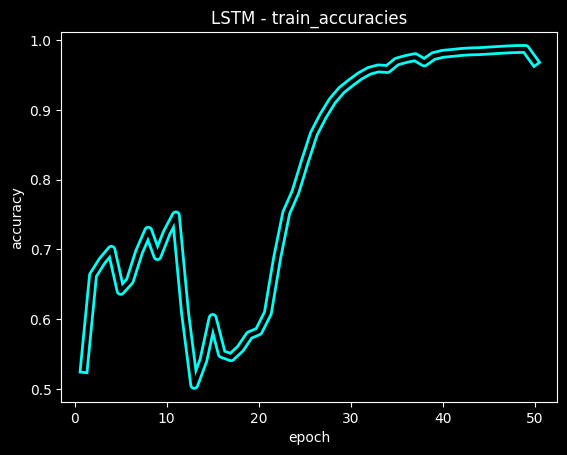

In [55]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,51)] , train_accuracies , color="#00fff4", linewidth=7)
plt.plot([ i for i in range(1,51)] , train_accuracies , color="black", linewidth=3)
plt.title("LSTM - train_accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

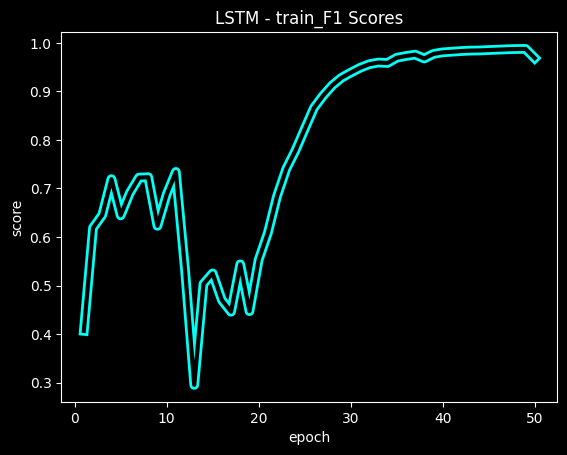

In [56]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,51)] , train_f1_scores , color="#00fff4", linewidth=7)
plt.plot([ i for i in range(1,51)] , train_f1_scores , color="black", linewidth=3)
plt.title("LSTM - train_F1 Scores")
plt.xlabel("epoch")
plt.ylabel("score")
plt.show()

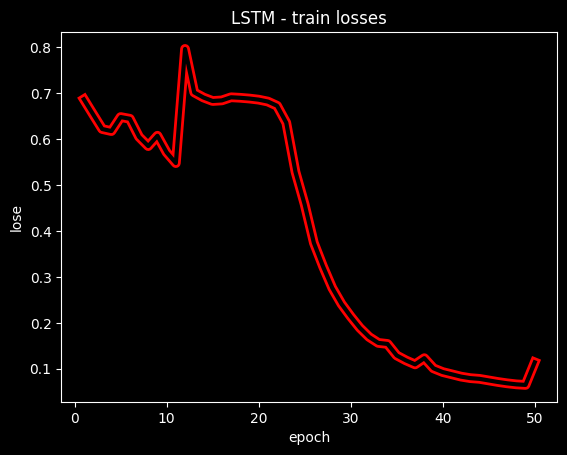

In [57]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,51)] , train_losses , color="red", linewidth=7)
plt.plot([ i for i in range(1,51)] , train_losses , color="black", linewidth=3)
plt.title("LSTM - train losses")
plt.xlabel("epoch")
plt.ylabel("lose")
plt.show()

# **Test Data**

In [52]:
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    avg_loss = test_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, zero_division=1)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.4f}, Test F1: {f1:.4f}")

evaluate(model, test_loader, criterion)

Test Loss: 0.5709, Test Acc: 0.8389, Test F1: 0.8458


Test Loss: 0.5709, Test Acc: 0.8389, Test F1: 0.8458


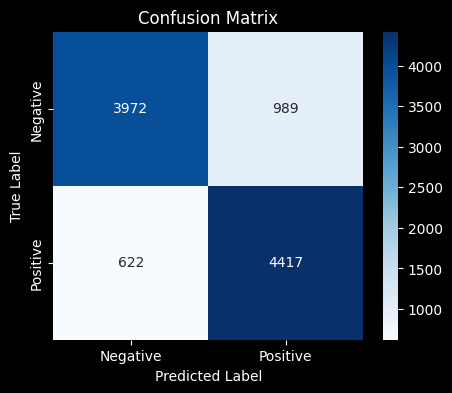

In [53]:
import seaborn as sns
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    avg_loss = test_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, zero_division=1)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.4f}, Test F1: {f1:.4f}")
    return avg_loss, accuracy, f1, np.array(all_targets), np.array(all_preds)
test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, criterion)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [54]:
torch.save(model.state_dict(), "model_weights_LSTM.pth")